In [ ]:
import json
import pandas as pd
import numpy as np
from nltk.parse.corenlp import CoreNLPParser,CoreNLPDependencyParser
import nltk
import stanza
from tqdm.auto import tqdm, trange
from datasets import load_dataset
import os
from numerize import numerize
# stanza.download('en') # download English model

In [ ]:
from tokenizers import Tokenizer
from tokenizers.trainers import WordLevelTrainer
from tokenizers.models import WordLevel
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.processors import TemplateProcessing
from transformers import PreTrainedTokenizer, PreTrainedTokenizerFast
from transformers import BertForMaskedLM, BertConfig
from transformers import DataCollatorForLanguageModeling
from transformers import Trainer, TrainingArguments

In [ ]:
import nltk 
from nltk.tag.hunpos import HunposTagger
from nltk.tokenize import word_tokenize

# tagger check

In [ ]:
def pprint(tag_sent):
    words = []
    tags = []
    for i in range(len(tag_sent)):
        words.append(tag_sent[i][0])
        tags.append(tag_sent[i][1].decode('utf-8') if isinstance(tag_sent[i][1], bytes) else tag_sent[i][1])  
    print('Sentences:\t', '\t'.join(words))
    print('POS tags:\t', '\t'.join(tags))    

In [ ]:
# hunpos
ht = HunposTagger('/home/jz17d/bin/english.model')

In [ ]:
# stanford corenlp 
pos_tagger = CoreNLPParser(url='http://localhost:9000', tagtype='pos')

In [ ]:
# stanza
nlp = stanza.Pipeline(lang='en', processors='tokenize,pos')

2022-11-02 11:46:52 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2022-11-02 11:46:56 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| pos       | combined |

2022-11-02 11:46:56 INFO: Use device: gpu
2022-11-02 11:46:56 INFO: Loading: tokenize
2022-11-02 11:47:16 INFO: Loading: pos
2022-11-02 11:47:18 INFO: Done loading processors!


In [ ]:
sentences = ['This is how I check. -- - --- :',
             'how to use "-" correctly?',
             "Nice to meet you. -Mia",
             "Why is that ( blabla ) happening?",
             'my number is 850-000-0000',
             "How about E=mc^2 and E = mc ^ 2?",
             "quotes? he said, 'Nice to meet you.'",
             "' Is it because of nltk.ssplit?' Yes",
             'My 6 y.o. boy like it.',
             "I gave him $200."]

In [ ]:
# hunpos
tagged = ht.tag_sents([word_tokenize(sent) for sent in sentences])
for sent in tagged:
    pprint(sent)

Sentences:	 This	is	how	I	check	.	--	-	--	-	:
POS tags:	 DT	VBZ	WRB	PRP	VBP	.	:	:	:	:	:
Sentences:	 how	to	use	``	-	''	correctly	?
POS tags:	 WRB	TO	VB	``	:	''	RB	.
Sentences:	 Nice	to	meet	you	.	-Mia
POS tags:	 JJ	TO	VB	PRP	.	NNP
Sentences:	 Why	is	that	(	blabla	)	happening	?
POS tags:	 WRB	VBZ	DT	JJ	NN	VBZ	VBG	.
Sentences:	 my	number	is	850-000-0000
POS tags:	 PRP$	NN	VBZ	CD
Sentences:	 How	about	E=mc^2	and	E	=	mc	^	2	?
POS tags:	 WRB	IN	NN	CC	NN	SYM	CD	CD	CD	.
Sentences:	 quotes	?	he	said	,	'Nice	to	meet	you	.	'
POS tags:	 NNS	.	PRP	VBD	,	NNP	TO	VB	PRP	.	''
Sentences:	 '	Is	it	because	of	nltk.ssplit	?	'	Yes
POS tags:	 ''	VBZ	PRP	IN	IN	JJ	.	''	UH
Sentences:	 My	6	y.o	.	boy	like	it	.
POS tags:	 PRP$	CD	NN	.	NN	IN	PRP	.
Sentences:	 I	gave	him	$	200	.
POS tags:	 PRP	VBD	PRP	$	CD	.


In [ ]:
# standford corenlp
tagged = list(pos_tagger.raw_tag_sents(sentences))
for sent in tagged:
    pprint(sent[0])

Sentences:	 This	is	how	I	check	.	--	-	---	:
POS tags:	 DT	VBZ	WRB	PRP	VBP	.	:	HYPH	NFP	:
Sentences:	 how	to	use	"	-	"	correctly	?
POS tags:	 WRB	TO	VB	''	,	``	RB	.
Sentences:	 Nice	to	meet	you	.	-	Mia
POS tags:	 JJ	TO	VB	PRP	.	NFP	NNP
Sentences:	 Why	is	that	(	blabla	)	happening	?
POS tags:	 WRB	VBZ	DT	-LRB-	FW	-RRB-	VBG	.
Sentences:	 my	number	is	850-000-0000
POS tags:	 PRP$	NN	VBZ	CD
Sentences:	 How	about	E	=	mc	^	2	and	E	=	mc	^	2	?
POS tags:	 WRB	IN	NN	SYM	NN	SYM	CD	CC	NN	SYM	NN	SYM	CD	.
Sentences:	 quotes	?	he	said	,	'	Nice	to	meet	you	.	'
POS tags:	 NNS	,	PRP	VBD	,	''	JJ	TO	VB	PRP	.	''
Sentences:	 '	Is	it	because	of	nltk.ssplit	?	'	Yes
POS tags:	 ``	VBZ	PRP	IN	IN	NNP	.	''	UH
Sentences:	 My	6	y.o.	boy	like	it	.
POS tags:	 PRP$	CD	NN	NN	IN	PRP	.
Sentences:	 I	gave	him	$	200	.
POS tags:	 PRP	VBD	PRP	$	CD	.


In [ ]:
# stanza
docs = [nlp(sent) for sent in sentences]
doc_upos = []
doc_xpos = []
for doc in docs:
    for sentence in doc.sentences:
        upos = []
        xpos = []
        for word in sentence.words:
            upos.append((word.text,word.upos))
            xpos.append((word.text,word.xpos))
        doc_upos.append(upos)
        doc_xpos.append(xpos)    
for sent in doc_xpos:
    pprint(sent)

Sentences:	 This	is	how	I	check	.
POS tags:	 DT	VBZ	WRB	PRP	VBP	.
Sentences:	 --	-	---	:
POS tags:	 NFP	,	NFP	:
Sentences:	 how	to	use	"	-	"	correctly	?
POS tags:	 WRB	TO	VB	``	HYPH	''	RB	.
Sentences:	 Nice	to	meet	you	.
POS tags:	 JJ	TO	VB	PRP	.
Sentences:	 -	Mia
POS tags:	 NFP	NNP
Sentences:	 Why	is	that	(	blabla	)	happening	?
POS tags:	 WRB	VBZ	DT	-LRB-	NN	-RRB-	VBG	.
Sentences:	 my	number	is	850-000-0000
POS tags:	 PRP$	NN	VBZ	CD
Sentences:	 How	about	E=mc^2	and	E	=	mc	^	2	?
POS tags:	 WRB	IN	NNP	CC	NNP	SYM	NNP	SYM	CD	.
Sentences:	 quotes	?
POS tags:	 NNS	.
Sentences:	 he	said	,	'	Nice	to	meet	you	.	'
POS tags:	 PRP	VBD	,	``	JJ	TO	VB	PRP	.	''
Sentences:	 '	Is	it	because	of	nltk.ssplit	?	'
POS tags:	 ``	VBZ	PRP	IN	IN	NN	.	''
Sentences:	 Yes
POS tags:	 UH
Sentences:	 My	6	y.o.	boy	like	it	.
POS tags:	 PRP$	CD	NN	NN	VBP	PRP	.
Sentences:	 I	gave	him	$	200	.
POS tags:	 PRP	VBD	PRP	$	CD	.


# dependency tree parser

In [ ]:
depparser = CoreNLPDependencyParser(url='http://localhost:9000')

In [ ]:
# parsed = depparser.raw_parse(sentences[-1])
# parsed = depparser.raw_parse('President Trump likes to make money.')
# 'I put the book in the box on the table.'
parsed = depparser.raw_parse('President Trump likes to make more and more money.')

In [ ]:
x = next(parsed)

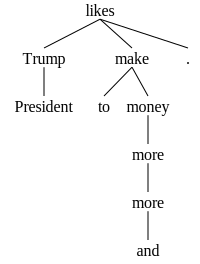

In [ ]:
x.tree()

In [ ]:
print(x.to_dot())

digraph G{
edge [dir=forward]
node [shape=plaintext]

0 [label="0 (None)"]
0 -> 3 [label="ROOT"]
0 -> 3 [label="ROOT"]
0 -> 1 [label="compound"]
0 -> 2 [label="nsubj"]
0 -> 4 [label="mark"]
0 -> 5 [label="xcomp"]
0 -> 6 [label="amod"]
0 -> 9 [label="obj"]
0 -> 7 [label="cc"]
0 -> 8 [label="conj"]
0 -> 10 [label="punct"]
1 [label="1 (President)"]
1 -> 0 
1 -> 2 [label="nsubj"]
1 -> 3 [label="ROOT"]
1 -> 4 [label="mark"]
1 -> 5 [label="xcomp"]
1 -> 6 [label="amod"]
1 -> 9 [label="obj"]
1 -> 7 [label="cc"]
1 -> 8 [label="conj"]
1 -> 10 [label="punct"]
2 [label="2 (Trump)"]
2 -> 1 [label="compound"]
2 -> 1 [label="compound"]
2 -> 0 
2 -> 3 [label="ROOT"]
2 -> 4 [label="mark"]
2 -> 5 [label="xcomp"]
2 -> 6 [label="amod"]
2 -> 9 [label="obj"]
2 -> 7 [label="cc"]
2 -> 8 [label="conj"]
2 -> 10 [label="punct"]
3 [label="3 (likes)"]
3 -> 2 [label="nsubj"]
3 -> 2 [label="nsubj"]
3 -> 5 [label="xcomp"]
3 -> 5 [label="xcomp"]
3 -> 10 [label="punct"]
3 -> 10 [label="punct"]
3 -> 0 
3 -> 1 [label="co

In [ ]:
list(x.triples())

[(('likes', 'VBZ'), 'nsubj', ('Trump', 'NNP')),
 (('Trump', 'NNP'), 'compound', ('President', 'NNP')),
 (('likes', 'VBZ'), 'xcomp', ('make', 'VB')),
 (('make', 'VB'), 'mark', ('to', 'TO')),
 (('make', 'VB'), 'obj', ('money', 'NN')),
 (('money', 'NN'), 'amod', ('more', 'JJR')),
 (('more', 'JJR'), 'conj', ('more', 'JJR')),
 (('more', 'JJR'), 'cc', ('and', 'CC')),
 (('likes', 'VBZ'), 'punct', ('.', '.'))]

In [ ]:
print(x.to_conll(4))

President	NNP	2	compound
Trump	NNP	3	nsubj
likes	VBZ	0	ROOT
to	TO	5	mark
make	VB	3	xcomp
more	JJR	9	amod
and	CC	8	cc
more	JJR	6	conj
money	NN	5	obj
.	.	3	punct



In [ ]:
G = x.nx_graph()
G

<networkx.classes.multidigraph.MultiDiGraph>

In [ ]:
G.nodes()

NodeView((1, 2, 3, 4, 5, 6, 7, 8, 9, 10))

In [ ]:
G.edges()

OutMultiEdgeDataView([(1, 2), (2, 3), (4, 5), (5, 3), (6, 9), (7, 8), (8, 6), (9, 5), (10, 3)])

In [ ]:
list(G.adjacency())

[(1, {2: {'compound': {}}}),
 (2, {3: {'nsubj': {}}}),
 (3, {}),
 (4, {5: {'mark': {}}}),
 (5, {3: {'xcomp': {}}}),
 (6, {9: {'amod': {}}}),
 (7, {8: {'cc': {}}}),
 (8, {6: {'conj': {}}}),
 (9, {5: {'obj': {}}}),
 (10, {3: {'punct': {}}})]

# amazon review

In [ ]:
# file = '../../data/amazon review 2018/Toys_and_Games_5.json'
import pandas as pd
import gzip

def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield json.loads(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

df = getDF('../../data/amazon review 2018/Toys_and_Games_5.json.gz')
df = df.dropna(subset=['reviewText'])

In [ ]:
def stanza_tag(df):
    nlp = stanza.Pipeline(lang='en', processors='tokenize,pos')
    all_num_sent = []
    all_num_word = []
    all_upos = []
    all_xpos = []
    for text in tqdm(df['reviewText']):
        doc = nlp(text)
    #     sentences = [sentence.text for sentence in doc.sentences]
        num_word = []
        doc_upos = []
        doc_xpos = []
        for sentence in doc.sentences:
            num_word.append(len(sentence.words))
            upos = []
            xpos = []
            for word in sentence.words:
                upos.append(word.upos)
                xpos.append(word.xpos)  
            doc_upos.append(upos)
            doc_xpos.append(xpos)    
        all_num_sent.append(len(doc.sentences))
        all_num_word.append(num_word)
        all_upos.append(doc_upos)
        all_xpos.append(doc_xpos)   
    df['all_num_sent'] = all_num_sent
    df['all_num_word'] = all_num_word    
    df['all_upos'] = all_upos    
    df['all_xpos'] = all_xpos    
    return df

In [ ]:
df5000 = df[:5000]
df5000 = stanza_tag(df5000)

2022-10-25 15:18:12 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2022-10-25 15:18:12 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| pos       | combined |

2022-10-25 15:18:12 INFO: Use device: gpu
2022-10-25 15:18:12 INFO: Loading: tokenize
2022-10-25 15:18:12 INFO: Loading: pos
2022-10-25 15:18:13 INFO: Done loading processors!


  0%|          | 0/5000 [00:00<?, ?it/s]

/tmp/ipykernel_4345/1336902853.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['all_num_sent'] = all_num_sent
/tmp/ipykernel_4345/1336902853.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['all_num_word'] = all_num_word
/tmp/ipykernel_4345/1336902853.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

In [ ]:
out_name = '../../data/amazon review 2018/Toys_and_Games_5_tagged5000.csv'
df5000.to_csv(out_name)

NameError: name 'df5000' is not defined

# bookcorpus

In [ ]:
nlp = stanza.Pipeline(lang='en', processors='tokenize,pos', )

2022-10-27 11:32:16 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2022-10-27 11:32:18 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| pos       | combined |

2022-10-27 11:32:19 INFO: Use device: gpu
2022-10-27 11:32:19 INFO: Loading: tokenize
2022-10-27 11:32:55 INFO: Loading: pos
2022-10-27 11:32:56 INFO: Done loading processors!


In [ ]:
os.environ['HF_DATASETS_CACHE'] = '/scratch/data_jz17d/hf_datasets_cache'
dataset = load_dataset("bookcorpus", cache_dir="/scratch/data_jz17d/hf_datasets_cache")

Reusing dataset bookcorpus (/scratch/data_jz17d/hf_datasets_cache/bookcorpus/plain_text/1.0.0/44662c4a114441c35200992bea923b170e6f13f2f0beb7c14e43759cec498700)


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
text = dataset['train'][134]['text']
text

'my room was just up the stairs , and it beckoned to me even though i was more interested in dinner .'

In [ ]:
doc = nlp(text,)

In [ ]:
print(*[f'word: {word.text}\tupos: {word.upos}\txpos: {word.xpos}\tfeats: {word.feats if word.feats else "_"}' for sent in doc.sentences for word in sent.words], sep='\n')

word: my	upos: PRON	xpos: PRP$	feats: Number=Sing|Person=1|Poss=Yes|PronType=Prs
word: room	upos: NOUN	xpos: NN	feats: Number=Sing
word: was	upos: AUX	xpos: VBD	feats: Mood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin
word: just	upos: ADV	xpos: RB	feats: _
word: up	upos: ADP	xpos: IN	feats: _
word: the	upos: DET	xpos: DT	feats: Definite=Def|PronType=Art
word: stairs	upos: NOUN	xpos: NNS	feats: Number=Plur
word: ,	upos: PUNCT	xpos: ,	feats: _
word: and	upos: CCONJ	xpos: CC	feats: _
word: it	upos: PRON	xpos: PRP	feats: Case=Nom|Gender=Neut|Number=Sing|Person=3|PronType=Prs
word: beckoned	upos: VERB	xpos: VBD	feats: Mood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin
word: to	upos: ADP	xpos: IN	feats: _
word: me	upos: PRON	xpos: PRP	feats: Case=Acc|Number=Sing|Person=1|PronType=Prs
word: even	upos: ADV	xpos: RB	feats: _
word: though	upos: SCONJ	xpos: IN	feats: _
word: i	upos: PRON	xpos: PRP	feats: Case=Nom|Number=Sing|Person=1|PronType=Prs
word: was	upos: AUX	xpos: VBD	feats: Mood=I

In [ ]:
dataset['train']

Dataset({
    features: ['text'],
    num_rows: 74004228
})

In [ ]:
def POS_tagging(example):
    if isinstance(example['text'], list):
        upos = []
        xpos = []
        for text in example['text']:
            doc = nlp(text)
            upos.append(' '.join([word.upos for sentence in doc.sentences for word in sentence.words]))
            xpos.append(' '.join([word.xpos for sentence in doc.sentences for word in sentence.words]))
    else:
        doc = nlp(example['text'])
        upos = ' '.join([word.upos for sentence in doc.sentences for word in sentence.words])
        xpos = ' '.join([word.xpos for sentence in doc.sentences for word in sentence.words])
    return {'upos':upos, 'xpos':xpos}
dataset['train'].set_transform(POS_tagging)

In [ ]:
dataset['train'][134]

{'upos': 'PRON NOUN AUX ADV ADP DET NOUN PUNCT CCONJ PRON VERB ADP PRON ADV SCONJ PRON AUX ADV ADJ ADP NOUN PUNCT',
 'xpos': 'PRP$ NN VBD RB IN DT NNS , CC PRP VBD IN PRP RB IN PRP VBD RBR JJ IN NN .'}